# Problem 2: Dogs vs. Cats Classification
We first import some libraries, define the data loader and training procedures. We will define the first simple model below

In [1]:
from __future__ import print_function
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable


# Plotting
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [23]:
batch_size = 256
epochs = 50
lr = 3e-4
cuda = torch.cuda.is_available()
print('Using cuda:', cuda)
init = 'glorot_uniform'

Using cuda: True


In [3]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}



train_set = datasets.ImageFolder(root='/data/milatmp1/thomasva/data/competitions/dogsvscats/train_64x64',
                            transform=transforms.Compose([
                                transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))

val_set = datasets.ImageFolder(root='/data/milatmp1/thomasva/data/competitions/dogsvscats/valid_64x64',
                            transform=transforms.Compose([
                                transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))

train_loader = torch.utils.data.DataLoader(
        train_set, shuffle=True,
        batch_size=batch_size, **kwargs)

valid_loader = torch.utils.data.DataLoader(
        val_set, shuffle=True,
        batch_size=batch_size, **kwargs)

In [4]:
def train(loader, epoch, net):
    net.train()
    loss_tot = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target).unsqueeze(1).float()
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)

        pred = output.data.round()
        correct += pred.eq(target.data.view_as(pred)).cpu().float().mean()
        loss_tot += loss.data[0]

        loss.backward()
        optimizer.step()

        #if batch_idx % log_interval == 0:
        #    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, batch_idx * len(data), len(loader.dataset),
        #        100. * batch_idx / len(loader), loss.data[0]))
    steps = batch_idx + 1
    return loss_tot/steps, correct/steps

def test(loader, net):
    net.eval()
    test_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target).unsqueeze(1).float()
        output = net(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.round()
        correct += pred.eq(target.data.view_as(pred)).cpu().float().mean()

    steps = batch_idx + 1
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss/steps, int(correct/steps*len(loader.dataset)), len(loader.dataset),
        100. * correct / steps))
    return test_loss / steps, correct / steps

In [5]:
def init_glorot_uniform(m):
    gain = nn.init.calculate_gain('relu')
    if type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight,gain=gain)
        nn.init.constant(m.bias,0)

def init_glorot_normal(m):
    gain = nn.init.calculate_gain('relu')
    if type(m) == nn.Linear:
        nn.init.xavier_normal(m.weight,gain=gain)
        nn.init.constant(m.bias,0)

In [6]:
def nparams(model):
    return sum(p.numel() for p in model.parameters())

## (a) Architecture
### A first simple model
For the first model, we took inspiration from the DCGAN's discriminator architecture which only has convolutional layers to beginning to end.
This has a fairly low number of parameters and is training is faster that with big linear layers.

The network has 5 convolutional layers and uses ReLU activations.
The simplest way to explain this architecture is to say that each convolutional layer reduces the feature map size by 2 on each dimension (because of the stride of 2, and the padding of 1), and we augment the number of channels by 2 everytime.

We do not use dilations, and we do not use batchnorm or any regularization here.

The number of parameters in this model is 2,764,737

In this part and the following, we always use the Adam optimizer with default $\beta$ parameters and a learning rate of 1e-4. While we could probably achieve better generalization (and accuracy!) with plain SGD, this would require a bit of tuning and Adam works pretty well out of the box

In [7]:
class netCNN5(nn.Module):
    def __init__(self):
        super(netCNN5, self).__init__()
        self.main = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=True),
            nn.ReLU(inplace=True),
            # size 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=True),
            nn.ReLU(inplace=True),
            # size 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=True),
            nn.ReLU(inplace=True),
            # size 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=True),
            nn.ReLU(inplace=True),
            # size 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=True),
            # size 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)

In [8]:
model = netCNN5()
criterion = nn.BCELoss()


if init == 'glorot_uniform':
    model.apply(init_glorot_uniform)
elif init == 'glorot_normal':
    model.apply(init_glorot_normal)


if cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)

list_err_tr = []
list_loss_tr = []
list_err_val = []
list_loss_val = []
best_valid_acc = 0

for epoch in range(1, epochs + 1):
    print('Epoch', epoch, '/', epochs)
    train_loss, train_acc = train(train_loader, epoch, model)
    #train_loss, train_acc = test(train_loader, model)
    valid_loss, valid_acc = test(valid_loader, model)
    
    list_err_tr.append(1-train_acc)
    list_loss_tr.append(train_loss)
    list_err_val.append(1-valid_acc)
    list_loss_val.append(valid_loss)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc

print('Best valid accuracy:', best_valid_acc)

Epoch 1 / 50

Test set: Average loss: 0.6293, Accuracy: 3262/4999 (65%)

Epoch 2 / 50

Test set: Average loss: 0.5872, Accuracy: 3440/4999 (69%)

Epoch 3 / 50

Test set: Average loss: 0.5628, Accuracy: 3546/4999 (71%)

Epoch 4 / 50

Test set: Average loss: 0.5509, Accuracy: 3601/4999 (72%)

Epoch 5 / 50

Test set: Average loss: 0.5299, Accuracy: 3701/4999 (74%)

Epoch 6 / 50

Test set: Average loss: 0.5183, Accuracy: 3766/4999 (75%)

Epoch 7 / 50

Test set: Average loss: 0.5044, Accuracy: 3791/4999 (76%)

Epoch 8 / 50

Test set: Average loss: 0.5014, Accuracy: 3808/4999 (76%)

Epoch 9 / 50

Test set: Average loss: 0.4999, Accuracy: 3786/4999 (76%)

Epoch 10 / 50

Test set: Average loss: 0.4990, Accuracy: 3800/4999 (76%)

Epoch 11 / 50

Test set: Average loss: 0.5166, Accuracy: 3769/4999 (75%)

Epoch 12 / 50

Test set: Average loss: 0.4734, Accuracy: 3871/4999 (77%)

Epoch 13 / 50

Test set: Average loss: 0.4713, Accuracy: 3900/4999 (78%)

Epoch 14 / 50

Test set: Average loss: 0.4956, 

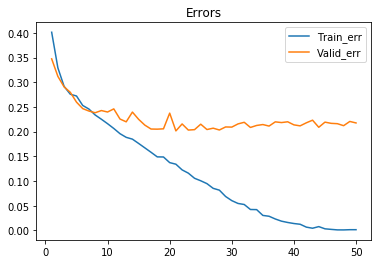

In [9]:
plt.plot(np.arange(1, epochs+1), list_err_tr, label='Train_err')
plt.plot(np.arange(1, epochs+1), list_err_val, label='Valid_err')
plt.title('Errors')
plt.legend()

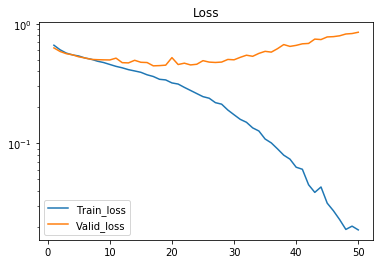

In [10]:
plt.semilogy(np.arange(1, epochs+1), list_loss_tr, label='Train_loss')
plt.semilogy(np.arange(1, epochs+1), list_loss_val, label='Valid_loss')
plt.title('Loss')
plt.legend()

#### Observations
First thing to notice is that we reach the reasonable accuracy of 86.6%. However, we also notice that we overfit from the beginning: while we do not see our validation accuracy rise, the validation loss grows over time and the generalization gap is pretty high.

## (b) Improving the model
### A better model
We now consider an improvement over the previous model. To tackle the generalization issue, we will
- reduce the number of parameters of the model by using filters of size $(3, 3)$ (mostly)
- add explicit regularization (Dropout here)
- use data augmentation on the training set

We do also make use of classical deep learning techniques such as MaxPooling and BatchNormalization. We also use LeakyReLU instead of ReLU as it can increase a bit our accuracy.

This model has 1,560,961 parameters.




In [16]:
class betterNet(nn.Module):
    def __init__(self):
        super(betterNet, self).__init__()
        self.main = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(3, 64, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2),    
            # size 64 x 32 x 32
            nn.Conv2d(64, 128, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),
            # size 128 x 16 x 16
            nn.Conv2d(128, 256, 3, 1, 1, bias=True),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),
            # size 256 x 8 x 8
            nn.Conv2d(256, 512, 3, 1, 1, bias=True),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout2d(0.2),
            nn.MaxPool2d(2),
            # size 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=True),
            # size 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)

Notice that to increase the performance of our model, we add some data augmentation to the training set. Namely we add some random horizontal flippings, some random brightness change and small random rotations to the input.

In [17]:

train_set = datasets.ImageFolder(root='/data/milatmp1/thomasva/data/competitions/dogsvscats/train_64x64',
                            transform=transforms.Compose([
                                transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
train_loader = torch.utils.data.DataLoader(
        train_set, shuffle=True,
        batch_size=batch_size, **kwargs)

In [24]:
model = betterNet()
criterion = nn.BCELoss()
epochs = 70

if init == 'glorot_uniform':
    model.apply(init_glorot_uniform)
elif init == 'glorot_normal':
    model.apply(init_glorot_normal)


if cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)

list_err_tr2 = []
list_loss_tr2 = []
list_err_val2 = []
list_loss_val2 = []
best_valid_acc2 = 0

for epoch in range(1, epochs + 1):
    print('Epoch', epoch, '/', epochs)
    train_loss, train_acc = train(train_loader, epoch, model)
    #train_loss, train_acc = test(train_loader, model)
    valid_loss, valid_acc = test(valid_loader, model)
    
    list_err_tr2.append(1-train_acc)
    list_loss_tr2.append(train_loss)
    list_err_val2.append(1-valid_acc)
    list_loss_val2.append(valid_loss)
    
    if valid_acc > best_valid_acc2:
        best_valid_acc2 = valid_acc

print('Best valid accuracy:', best_valid_acc2)

Epoch 1 / 70

Test set: Average loss: 0.5364, Accuracy: 3680/4999 (74%)

Epoch 2 / 70

Test set: Average loss: 0.4854, Accuracy: 3849/4999 (77%)

Epoch 3 / 70

Test set: Average loss: 0.4862, Accuracy: 3846/4999 (77%)

Epoch 4 / 70

Test set: Average loss: 0.4554, Accuracy: 3904/4999 (78%)

Epoch 5 / 70

Test set: Average loss: 0.4063, Accuracy: 4094/4999 (82%)

Epoch 6 / 70

Test set: Average loss: 0.4651, Accuracy: 3912/4999 (78%)

Epoch 7 / 70

Test set: Average loss: 0.3740, Accuracy: 4150/4999 (83%)

Epoch 8 / 70

Test set: Average loss: 0.4134, Accuracy: 4066/4999 (81%)

Epoch 9 / 70

Test set: Average loss: 0.3383, Accuracy: 4253/4999 (85%)

Epoch 10 / 70

Test set: Average loss: 0.3361, Accuracy: 4266/4999 (85%)

Epoch 11 / 70

Test set: Average loss: 0.3138, Accuracy: 4307/4999 (86%)

Epoch 12 / 70

Test set: Average loss: 0.3302, Accuracy: 4247/4999 (85%)

Epoch 13 / 70

Test set: Average loss: 0.3116, Accuracy: 4327/4999 (87%)

Epoch 14 / 70

Test set: Average loss: 0.2957, 

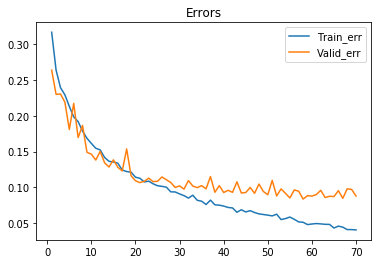

In [25]:
plt.plot(np.arange(1, epochs+1), list_err_tr2, label='Train_err')
plt.plot(np.arange(1, epochs+1), list_err_val2, label='Valid_err')
plt.title('Errors')
plt.legend()

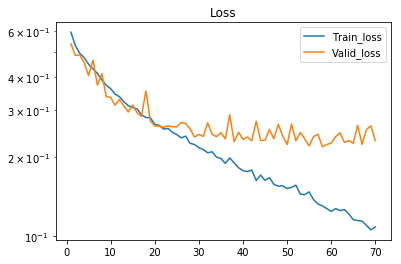

In [26]:
plt.semilogy(np.arange(1, epochs+1), list_loss_tr2, label='Train_loss')
plt.semilogy(np.arange(1, epochs+1), list_loss_val2, label='Valid_loss')
plt.title('Loss')
plt.legend()

#### Observations
Our new model is indeed more performant. The accuracy gap is lower and we reach a better accuracy (around 91.5%).

### Different hyperparameters


## (c) Visualization
### Errors
Let's visualize some images where our algorithm is wrong

In [27]:
n_im = 6
counter = 0
worst_examples = []
model.eval()
for batch_idx, (data, target) in enumerate(valid_loader):
    if cuda:
        data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target).unsqueeze(1).float()
    output = model(data)
    pred = output.data.round()
    for i in range(batch_size):
        if  (output[i]-target[i]).abs().data.mean() > 0.95:
            worst_examples.append([data[i].data.cpu(), output[i].data[0], target[i].data[0]])
            counter += 1
    if counter >= n_im:
        break
                                   
   

In [28]:
from torchvision.transforms import ToPILImage
torch2pil = ToPILImage()

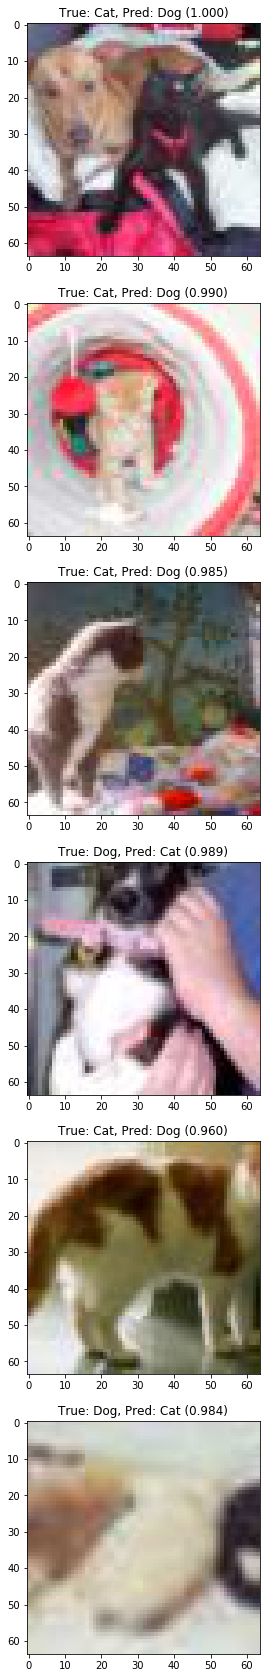

In [29]:
plt.figure(figsize=(40,30))
for i in range(n_im):
    plt.subplot(6, 1, i+1)
    plt.imshow(torch2pil(.5*worst_examples[i][0]+.5))
    if worst_examples[i][2] == 1:
        plt.title(f'True: Dog, Pred: Cat ({1-worst_examples[i][1]:.3f})')
    else:
        plt.title(f'True: Cat, Pred: Dog ({worst_examples[i][1]:.3f})')

